In [20]:
# import basic libraries
import pickle
import yt
import numpy as np
import matplotlib.pyplot as plt
from math import log, log10, pi
from astropy import units as u

# import halo catalogue func
from yt.analysis_modules.halo_analysis.api import *

In [21]:
# import libraries - not sure what they do
# used to ensure halo catalog loads properly
import tempfile
import shutil
import os

# Create temporary directory for storing files
tmpdir = tempfile.mkdtemp()

In [22]:
# load halo dataset
halos_ds = yt.load('./LG4_2048_40pc/rd0070/halo_catalogs/catalog/catalog0070_thres160.0.h5')

# load raw dataset
ds = yt.load('~/../../tigress/cen/LG4_2048_40pc/RD0070/redshift0070')

# Instantiate a catalog using those two paramter files
hc = HaloCatalog(halos_ds=halos_ds, output_dir=os.path.join(tmpdir, 'halo_catalog'))
hc.load()

yt : [INFO     ] 2017-07-17 09:52:38,594 Parameters: current_time              = 3.75573046409e+16
yt : [INFO     ] 2017-07-17 09:52:38,596 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2017-07-17 09:52:38,597 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-07-17 09:52:38,598 Parameters: domain_right_edge         = [  2.22535525e+25   2.22535525e+25   2.22535525e+25]
yt : [INFO     ] 2017-07-17 09:52:38,600 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-07-17 09:52:38,601 Parameters: current_redshift          = 4.99999998323
yt : [INFO     ] 2017-07-17 09:52:38,601 Parameters: omega_lambda              = 0.712
yt : [INFO     ] 2017-07-17 09:52:38,602 Parameters: omega_matter              = 0.288
yt : [INFO     ] 2017-07-17 09:52:38,603 Parameters: hubble_constant           = 0.6933
yt : [INFO     ] 2017-07-17 09:52:38,744 Parameters: current_time              = 158.01757996843
yt : [INFO     ] 2017-07-17 09:52:38,745 Param

In [61]:
# load redshift and Omega values from parameter file
with open(redshift_filename, 'rt') as param_file:
    param_contents = param_file.read()
    
    #redshift
    cindex1 = param_contents.find('CosmologyCurrentRedshift')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    redshift = float(param_contents[cindex_eq+2:cindex2])
    
    # omega_m
    cindex1 = param_contents.find('CosmologyOmegaMatterNow')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    omega_m = float(param_contents[cindex_eq+2:cindex2])
    
    # hubble const now
    cindex1 = param_contents.find('CosmologyHubbleConstantNow')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    hubb_now = float(param_contents[cindex_eq+2:cindex2]) *(u.km / u.s / u.Mpc) 
    
    # cosmological constant
    cindex1 = param_contents.find('CosmologyOmegaLambdaNow')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    cos_const = float(param_contents[cindex_eq+2:cindex2])
    
    # omega baryon as specified by Renyue
    omega_b = 0.048
    
    # box size
    cindex1 = param_contents.find('CosmologyComovingBoxSize')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    box_size = float(param_contents[cindex_eq+2:cindex2]) * u.Mpc
    
    # left edge strings
    cindex1 = param_contents.find('RefineRegionLeftEdge')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    left_edge_string = param_contents[cindex_eq+2:cindex2]
    left_edges = left_edge_string.split()
    
    # right edge strings
    cindex1 = param_contents.find('RefineRegionRightEdge')
    cindex_eq = param_contents.find('=', cindex1)
    cindex2 = param_contents.find('\n', cindex_eq, cindex_eq + 100)
    right_edge_string = param_contents[cindex_eq+2:cindex2]
    right_edges = right_edge_string.split()
    
# calculate hubble const for simulation
hubb_z = (100* hubb_now.to('s**-1')) * ((omega_m * (1 + redshift)**3) + (1 - omega_m))**0.5

# calculate crit density and threshold
GRAV_CONST = (6.67408e-11 * u.m**3 /(u.kg * u.s**2)).to('cm^3*g^-1*s^-2')
crit_dens = (3 * hubb_z**2) / (8 * pi * GRAV_CONST)
omegas = (1 - (omega_b / omega_m))
threshold = 200 * omegas * crit_dens

# min and max bounds for radial profile
# min = 1 kpc proper
# max = 0.5 Mpc comoving
# convert to centimeters value (without astropy units)
rad_min = 1 * u.kpc
rad_max = 0.5 * u.Mpc
rad_max = rad_max / (1 + redshift) # convert to physical

# specify boundaries of zoom-in box
# scaling factor multiplied by info from text file 
# units in cm
scaling =  ((box_size / hubb_now.value) / (1 + redshift)).to('kpc') # size of box
xmin = scaling*float(left_edges[0])
ymin = scaling*float(left_edges[1])
zmin = scaling*float(left_edges[2])
xmax = scaling*float(right_edges[0])
ymax = scaling*float(right_edges[1])
zmax = scaling*float(right_edges[2])

In [65]:
# --load ratio of stellar mass to halo mass
# first list uses first output of TotalMass funct
# second list uses second output

with open('./LG4_2048_40pc/rd0070/ratio_list0070_1.txt', 'rb') as ratiofile1:
    ratiolist1 = pickle.load(ratiofile1)
    
with open('./LG4_2048_40pc/rd0070/ratio_list0070_2.txt', 'rb') as ratiofile2:
    ratiolist2 = pickle.load(ratiofile2)
    
# load newly calculated python halo list
with open('./LG4_2048_40pc/rd0070/calc_list0070_2000', 'rb') as file1:
    halo_list = pickle.load(file1)

In [74]:
halo_list[87]

[87,
 9057,
 <Quantity 3674.968024750881 kpc>,
 <Quantity 3804.0572085595463 kpc>,
 <Quantity 3797.6349755704737 kpc>,
 <Quantity 2379445703.74642 solMass>,
 <Quantity 1999615383.7995045 solMass>,
 <Quantity 6.969164615034646 kpc>,
 <Quantity 9.389828800840391 kpc>,
 -1,
 -1]

In [73]:
# create new ratio lists
# < 3e7 Msun, < 3e8 Msun, > 3e8 Msun
new_ratiolist1 = []
new_ratiolist2 = []
new_ratiolist3 = []
mass_ratio_list = []

for halo in halo_list:
    # find parameters of halo
    x = halo[2]
    y = halo[3]
    z = halo[4]
    center = [(x/scaling).value, (y/scaling).value, (z/scaling).value]
    halo_mass = halo[5] # new mass
    radius = halo[7] # new radius
    isSatellite = halo[9]
    ratio1 = halo[10] # Mgas / Mhalo
    
    # check if halo is inside zoom-in box
    if xmin <= x < xmax and ymin <= y < ymax and zmin <= z < zmax:
        pass
    else:
        continue

    # check that radius is not 0
    if radius == 0:
        continue

    # check that not a satellite 
    if isSatellite >= 0:
        continue
    
#     # create a sphere data object with halo position and radius
#     sp = ds.sphere(center, (radius.to('cm').value, 'cm'))

#     # find the two output masses from TotalMass in Msun
#     masses = sp.quantities.total_mass()
#     gas_mass = masses[0] * u.g
#     particle_mass = masses[1] * u.g
#     gas_mass = gas_mass.to('Msun')
#     particle_mass = particle_mass.to('Msun')

#     # find stellar mass using total particle mass from TotalMass
#     stellar_mass = particle_mass.to('Msun') - (halo_mass*omegas).to('Msun')

#     # find the second ratio
#     ratio2 = particle_mass / halo_mass.to('Msun')
    
    # add ratio1 to diff lists based on halo mass
    if halo_mass < 3e7 * u.Msun:
        new_ratiolist1.append(ratio1)
    if halo_mass < 3e8 * u.Msun and halo_mass > 3e7 * u.Msun:
        new_ratiolist2.append(ratio1)
    if halo_mass > 3e8 * u.Msun:
        new_ratiolist3.append(ratio1)
    
#     # add ratio2 to it's own list
#     mass_ratio_list.append(ratio2)

IndexError: list index out of range

In [68]:
bins = np.geomspace(start=1e-4, stop=10**1.5, num=55)

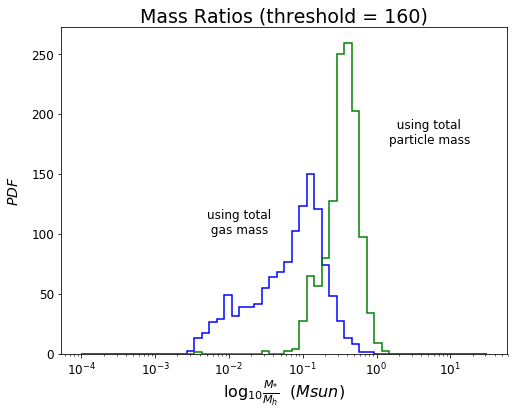

In [77]:
# Two subplots
fig = plt.figure(figsize = (8,6))
ax1 = fig.add_subplot(111)

# plot both ratio lists
ratiolists = [ratiolist1, ratiolist2]
ax1.hist(ratiolist1, bins, histtype='step', fill = False, ec = 'blue', lw = 1.5)
ax1.hist(ratiolist2, bins, histtype='step', fill = False, ec = 'green', lw = 1.5)
# ax1.hist(new_ratiolist3, bins, histtype='step', fill = False, ec = 'red', lw = 1.5)
#ax1.hist(mass_ratio_list, bins, histtype='step', fill = False, ec = 'orange', lw = 1.5)
ax1.set_title("Mass Ratios (threshold = 160)", size = 19)
#ax1.axis([1e-4, 10**1.5, 0, 700])

# create axis labels
xlab = r"$\log_{10}\frac{M_{*}}{M_h}$  $(Msun)$"
ylab = "$PDF$"
ax1.set_xlabel(xlab, size = 16, labelpad= 0)
ax1.set_ylabel(ylab, rotation = 90, size = 14, labelpad= 10)

# create axis ticks 
ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.tick_params(axis='x', which='major', labelsize=12)
ax1.tick_params(axis='y', which='major', labelsize=12)


# add labels for each plot
annotation1 = "using total \n gas mass"
annotation2 = "  using total\nparticle mass"
ax1.text(5e-3, 100, annotation1, size = 12)
ax1.text(1.5, 175, annotation2, size = 12)


plt.show()

#plt.savefig('./LG4_2048_40pc/rd0070/massratios.png', dpi = 300)

In [72]:
new_ratiolist2

[-1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,


In [124]:
# find log arrays for ratio lists
log_ratio1 = np.log(ratiolist1) / log(10)
log_ratio2 = np.log([value for value in ratiolist2 if value > 0]) / log(10)

# find histogram parameters
density1, bin_edges1 = np.histogram(log_ratio1, bins= np.linspace(-3.5, 0.4, 39))
density2, bin_edges2 = np.histogram(log_ratio2, bins= np.linspace(-2.2, 1.1, 33))


log_density1 = np.log(density1) / log(10)
log_density2 = np.log(density2) / log(10)

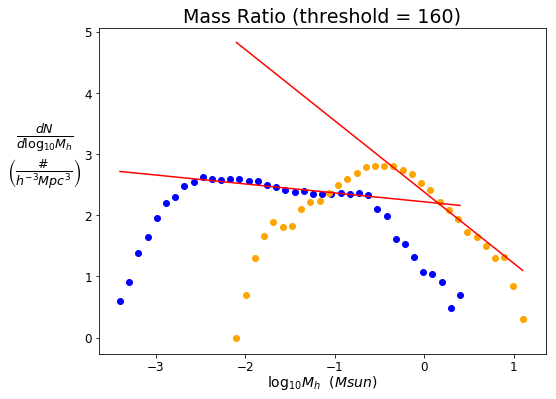

In [161]:
# specify figure size
fig2 = plt.figure(figsize=(8,6))
ax2 = fig2.add_subplot(111)

# --determine line of best fit
# reduce range of values to fit line
bin_edges_fit1 = bin_edges1[8:-10]
bin_edges_fit2 = bin_edges2[16:-4]
log_density_fit1 = log_density1[7:-10]
log_density_fit2 = log_density2[15:-4]
# determine line
par1 = np.polyfit(bin_edges_fit1, log_density_fit1, 1, full=True)
par2 = np.polyfit(bin_edges_fit2, log_density_fit2, 1, full=True)
slope1, intercept1 = par1[0][0], par1[0][1]
slope2, intercept2 = par2[0][0], par2[0][1]

# plot data and line
bin_edges_red1 = bin_edges1[1:]
bin_edges_red2 = bin_edges2[1:]
ax2.scatter(bin_edges_red1, log_density1, color = 'blue')
ax2.scatter(bin_edges_red2, log_density2, color = 'orange')
ax2.plot(bin_edges_red1, slope1 * bin_edges_red1 + intercept1, color = 'red')
ax2.plot(bin_edges_red2, slope2 * bin_edges_red2 + intercept2, color = 'red')
ax2.set_title("Mass Ratio (threshold = 160)", size = 19)

# create axis labels
xlab = "$\log_{10}M_h}$  $(Msun)$"
ylab = r"$\frac{dN}{d\log_{10}M_h}$"+"\n"+r"$\left(\frac{\#}{h^{-3}Mpc^3}\right)$"
ax2.set_xlabel(xlab, size = 14, labelpad= 0)
ax2.set_ylabel(ylab, rotation = 0, size = 18, labelpad= 40)

# create axis ticks 
ax2.set_yscale('linear')
ax2.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)

# add slope and intercept
# annotation = "$a = {:1.3f}$ \n$b = {:1.3f}$".format(slope, intercept)
# plt.text(9.5, 1.5, annotation, size = 12)

#show and save
plt.show()

In [156]:
print(bin_edges1[8:-4].size)
log_density1[7:-4].size

27


27